In [19]:
import numpy as np
import matplotlib.pyplot as plt
import time


In [20]:

# Simulation Parameters
np.random.seed(42) # RNG seeded for consistency

kappa = 5.0  # Ginzburg-Landau parameter
dt = 0.005
resolution = 100
points_per_plot_unit = 4
grid_size = resolution / points_per_plot_unit
Lx, Ly = grid_size, grid_size
Nx, Ny = resolution, resolution
H = 0.3  # External magnetic field

# Time evolution settings
n_steps = 10000
save_interval = 1000

# Damping coefficients and A evolution constraints to help with numerical stability
psi_damping = 1.0

A_damping = 8.0
A_update_interval = 3
max_dA = 0.1

# Toggles for initial vortex seeds and vector potential evolution
vortex_seeding = True
evolve_A_flag = False

print(f"Simulation Parameters:\nκ = {kappa}, dt = {dt}, H = {H}")
print(f"Resolution: {resolution}, Points per plot unit: {points_per_plot_unit}")
print(f"Vortex seeding is {"on" if vortex_seeding else "off"}, and vector potential evolution is {"on" if evolve_A_flag else "off"}")
print(f"ψ damping: {psi_damping}")
if evolve_A_flag:
    print(f"A damping: {A_damping}, A update interval: {A_update_interval}, Max change in A per timestep: {max_dA}")

# Initial Conditions
# For initial ψ, 0 is no superconductivity, and 1 is fully superconducting
initial_psi_amp = 0.5
noise_strength = 0.05

# Initialize close to equilibrium with small noise
psi = np.ones((Ny, Nx), dtype=complex) * initial_psi_amp
psi += noise_strength * (np.random.randn(Ny, Nx) + 1j * np.random.randn(Ny, Nx))

print(f"Initial Conditions: ψ_init = {initial_psi_amp}, noise = {noise_strength}")

Simulation Parameters:
κ = 5.0, dt = 0.005, H = 0.3
Resolution: 100, Points per plot unit: 4
Vortex seeding is on, and vector potential evolution is off
ψ damping: 1.0
Initial Conditions: ψ_init = 0.5, noise = 0.05


In [21]:
# Grid Setup
x = np.linspace(0, Lx, Nx, endpoint=True)
y = np.linspace(0, Ly, Ny, endpoint=True)
dx = x[1] - x[0]
dy = y[1] - y[0]
X, Y = np.meshgrid(x, y)

# Create hexagonal lattice with correct spacing (if enabled)
if vortex_seeding:
    vortex_positions = []
    core_size_relative = 1.5 # Arbitrary vortex scale

    # For field H, the vortex density is n = H/(flux quantum) = H in these units
    # The average spacing between vortices: a ≈ 1/sqrt(n) = 1/sqrt(H)
    # For hexagonal lattice: a_hex ≈ sqrt(2*sqrt(3)/H) 

    a_vortex = np.sqrt(2 * np.sqrt(3) / H)

    n_x = int(Lx / a_vortex) + 1
    n_y = int(Ly / (a_vortex * np.sqrt(3) / 2)) + 1

    # Hexagonal lattice
    for j in range(n_y):
        for i in range(n_x):
            x_pos = i * a_vortex + 0.5 * a_vortex * (j % 2)
            y_pos = j * a_vortex * np.sqrt(3) / 2
            
            if 0.5 < x_pos < Lx - 0.5 and 0.5 < y_pos < Ly - 0.5:
                vortex_positions.append((x_pos, y_pos))

    # Seed vortices
    for vx, vy in vortex_positions:
        phase_wind = np.arctan2(Y - vy, X - vx)
        dist = np.sqrt((X - vx)**2 + (Y - vy)**2)

        # Vortex core size ~ coherence length
        vortex_profile = np.tanh(dist / (core_size_relative * dx))
        psi *= vortex_profile * np.exp(1j * phase_wind)

    print(f"Seeded: {len(vortex_positions)} vortices in hexagonal pattern\n")

# Magnetic vector potential using Landau gauge
Ax = np.zeros_like(X)
Ay = H * X

Seeded: 56 vortices in hexagonal pattern



In [22]:
# Computation functions, will put into a TDGLSimulation library later 

def laplacian_cov_2D_fd(psi, Ax, Ay, dx):
    """Covariant finite-difference 2D Laplacian"""

    Ax_xp = 0.5 * (Ax + np.roll(Ax, -1, axis=1))
    Ax_xm = 0.5 * (Ax + np.roll(Ax, 1, axis=1))
    Ay_yp = 0.5 * (Ay + np.roll(Ay, -1, axis=0))
    Ay_ym = 0.5 * (Ay + np.roll(Ay, 1, axis=0))
    
    psi_xp = np.roll(psi, -1, axis=1) * np.exp(-1j * Ax_xp * dx)
    psi_xm = np.roll(psi, 1, axis=1) * np.exp(1j * Ax_xm * dx)
    psi_yp = np.roll(psi, -1, axis=0) * np.exp(-1j * Ay_yp * dx)
    psi_ym = np.roll(psi, 1, axis=0) * np.exp(1j * Ay_ym * dx)
    
    lap = (psi_xp + psi_xm + psi_yp + psi_ym - 4 * psi) / dx**2
    return lap

def evolve_psi(psi, Ax, Ay, dt, dx, damping=1.0):
    """Evolve order parameter with a damping coefficient"""
    nonlinear_term = (1 - np.abs(psi)**2) * psi
    laplacian_term = laplacian_cov_2D_fd(psi, Ax, Ay, dx)

    dpsi_dt = (nonlinear_term + laplacian_term) / damping
    psi_new = psi + dt * dpsi_dt
    
    return psi_new

def covariant_derivative_2D_fd(psi, Ax, Ay, dx):
    """Covariant finite difference derivative in 2D"""
    dpsi_dx = (np.roll(psi, -1, axis=1) - np.roll(psi, 1, axis=1)) / (2 * dx)
    dpsi_dy = (np.roll(psi, -1, axis=0) - np.roll(psi, 1, axis=0)) / (2 * dx)
    
    return dpsi_dx - 1j * Ax * psi, dpsi_dy - 1j * Ay * psi

def supercurrent(psi, Ax, Ay, dx):
    """Calculate supercurrent density J = Im[ψ*(D_μ ψ)]"""
    Dx_psi, Dy_psi = covariant_derivative_2D_fd(psi, Ax, Ay, dx)
    
    Jx = np.imag(np.conj(psi) * Dx_psi)
    Jy = np.imag(np.conj(psi) * Dy_psi)
    
    return Jx, Jy

def curl_2D_nonperiodic(Ax, Ay, dx):
    """Nonperiodic 2D finite difference curl
       using periodic boundary conditions would
       cause unwanted artifacts on the magnetic 
       field at the boundary"""
    Ny, Nx = Ax.shape

    dAy_dx = np.zeros_like(Ay)
    dAx_dy = np.zeros_like(Ax)

    dAy_dx[:, 1:-1] = (Ay[:, 2:] - Ay[:, :-2]) / (2*dx)
    dAx_dy[1:-1, :] = (Ax[2:, :] - Ax[:-2, :]) / (2*dx)

    dAy_dx[:, 0] = (Ay[:, 1] - Ay[:, 0]) / dx
    dAy_dx[:, -1] = (Ay[:, -1] - Ay[:, -2]) / dx

    dAx_dy[0, :] = (Ax[1, :] - Ax[0, :]) / dx
    dAx_dy[-1, :] = (Ax[-1, :] - Ax[-2, :]) / dx

    return dAy_dx - dAx_dy

def evolve_A(psi, Ax, Ay, dt, dx, kappa, H, X, Y, damping=1.0, max_dA=0.1):
    """Evolve vector potential with damping coefficient and 
       limit on magnitude difference"""
    Jx, Jy = supercurrent(psi, Ax, Ay, dx)
    
    Bz = curl_2D_nonperiodic(Ax, Ay, dx)
    
    dBz_dx = (np.roll(Bz, -1, axis=1) - np.roll(Bz, 1, axis=1)) / (2 * dx)
    dBz_dy = (np.roll(Bz, -1, axis=0) - np.roll(Bz, 1, axis=0)) / (2 * dx)
    
    # Maxwell equation: ∂A/∂t = -J - κ²∇(∇·A) + κ²∇×B
    # In 2D with Coulomb gauge (∇·A = 0): ∂A/∂t = -J + κ²(curl curl A)
    # curl curl A = (∂Bz/∂y, -∂Bz/∂x) in 2D
    
    # Equilibrium potential values
    Ax_eq = 0
    Ay_eq = H
    
    # Damping term and difference magnitude limit help with numerical instability
    dAx_dt = (Jx - kappa**2 * dBz_dy) / damping
    dAy_dt = (Jy + kappa**2 * dBz_dx) / damping
    dAx_dt = np.clip(dAx_dt, -max_dA, max_dA)
    dAy_dt = np.clip(dAy_dt, -max_dA, max_dA)
    
    Ax_new = Ax + dt * dAx_dt
    Ay_new = Ay + dt * dAy_dt
    
    return Ax_new, Ay_new

In [23]:
# Time Evolution
psi_history = []
A_history = []
time_points = []

print("Starting Simulation...")
print(f"A evolution: {'ENABLED' if evolve_A_flag else 'DISABLED (fixed external field)'}\n")
start = time.time()

last_save_time = start
last_save_step = 0
for step in range(n_steps):

    psi = evolve_psi(psi, Ax, Ay, dt, dx, damping=psi_damping)
    
    if evolve_A_flag and step % A_update_interval == 0:
        Ax, Ay = evolve_A(psi, Ax, Ay, dt * A_update_interval, dx, kappa, H, X, Y, damping=A_damping, max_dA=max_dA)
    
    if step % save_interval == 0:
        psi_history.append(psi.copy())
        A_history.append((Ax.copy(), Ay.copy()))
        time_points.append(step * dt)
        
        max_psi = np.max(np.abs(psi))
        min_psi = np.min(np.abs(psi))
        avg_psi = np.mean(np.abs(psi))
        
        print(f"t={step*dt:.1f} | |ψ|: min={min_psi:.3f}, avg={avg_psi:.3f}, max={max_psi:.3f} | Time elapsed for steps {last_save_step} to {step}: {time.time() - last_save_time:.2f}s")
        last_save_step = step
        last_save_time = time.time()
        
        if np.isnan(max_psi) or max_psi > 2.0:
            print("Instability detected! Stopping simulation.")
            break

elapsed = time.time() - start
print(f"\nSimulation Complete! Time: {elapsed:.2f}s")
print(f"Final time: t = {time_points[-1]:.1f}")

Starting Simulation...
A evolution: DISABLED (fixed external field)

t=0.0 | |ψ|: min=0.029, avg=0.440, max=0.596 | Time elapsed for steps 0 to 0: 0.00s
t=5.0 | |ψ|: min=0.002, avg=0.213, max=0.505 | Time elapsed for steps 0 to 1000: 0.83s
t=10.0 | |ψ|: min=0.005, avg=0.685, max=0.959 | Time elapsed for steps 1000 to 2000: 0.82s
t=15.0 | |ψ|: min=0.011, avg=0.708, max=0.961 | Time elapsed for steps 2000 to 3000: 0.82s
t=20.0 | |ψ|: min=0.036, avg=0.717, max=0.956 | Time elapsed for steps 3000 to 4000: 0.82s
t=25.0 | |ψ|: min=0.018, avg=0.721, max=0.954 | Time elapsed for steps 4000 to 5000: 0.81s
t=30.0 | |ψ|: min=0.003, avg=0.724, max=0.951 | Time elapsed for steps 5000 to 6000: 0.81s
t=35.0 | |ψ|: min=0.016, avg=0.727, max=0.948 | Time elapsed for steps 6000 to 7000: 0.81s
t=40.0 | |ψ|: min=0.025, avg=0.729, max=0.947 | Time elapsed for steps 7000 to 8000: 0.82s
t=45.0 | |ψ|: min=0.026, avg=0.730, max=0.947 | Time elapsed for steps 8000 to 9000: 0.82s

Simulation Complete! Time: 8.18

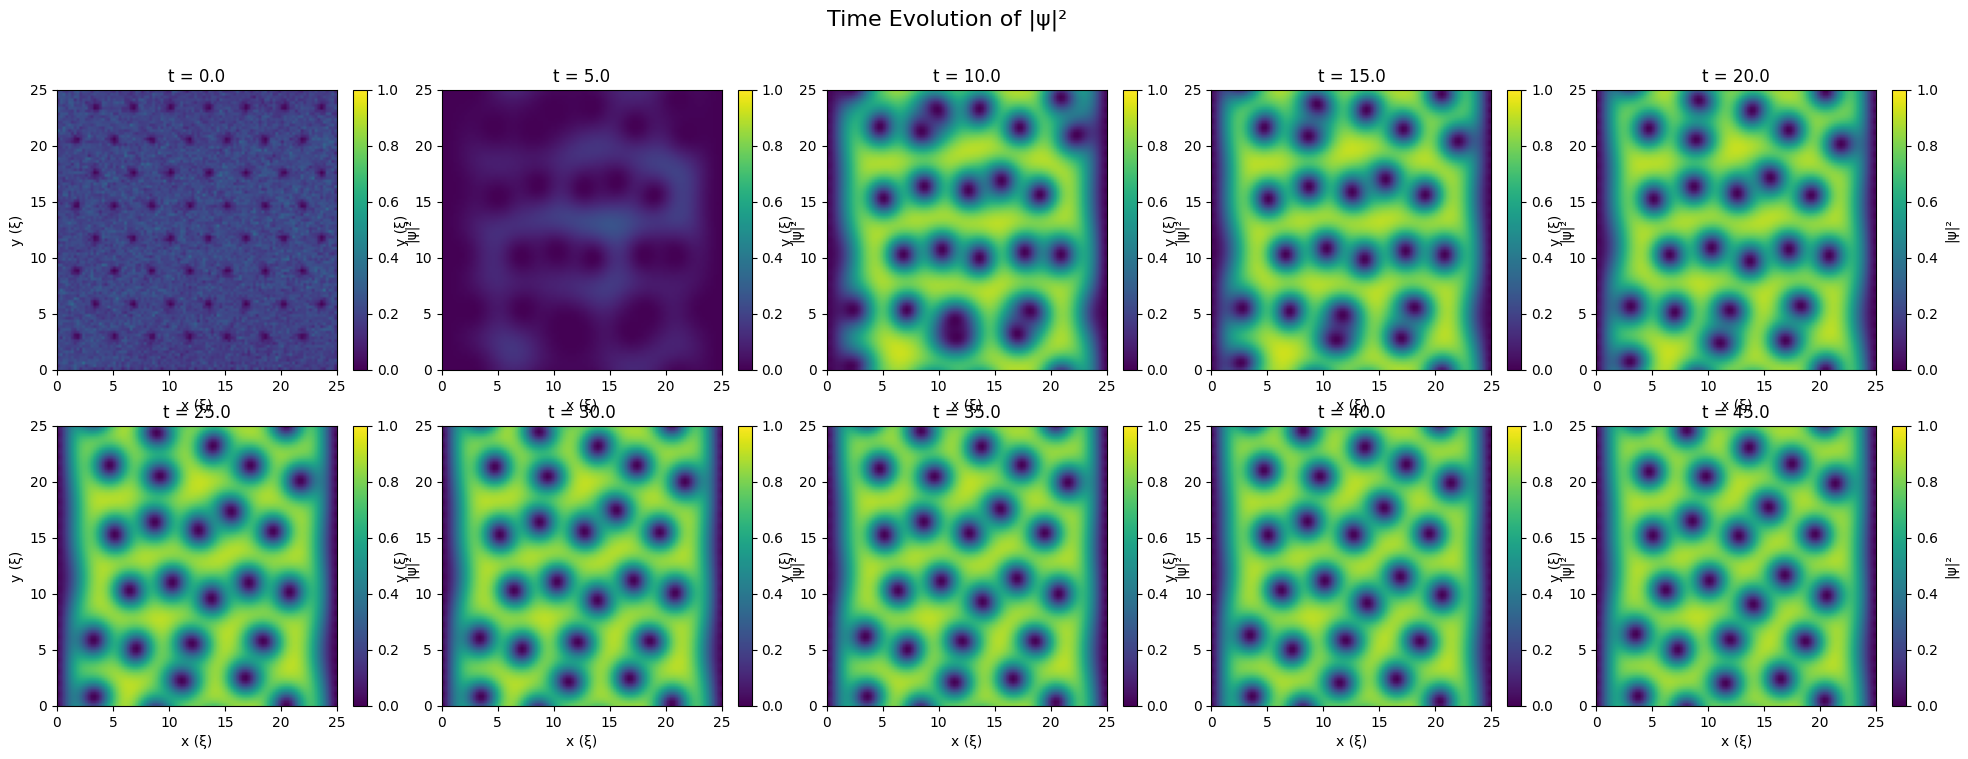

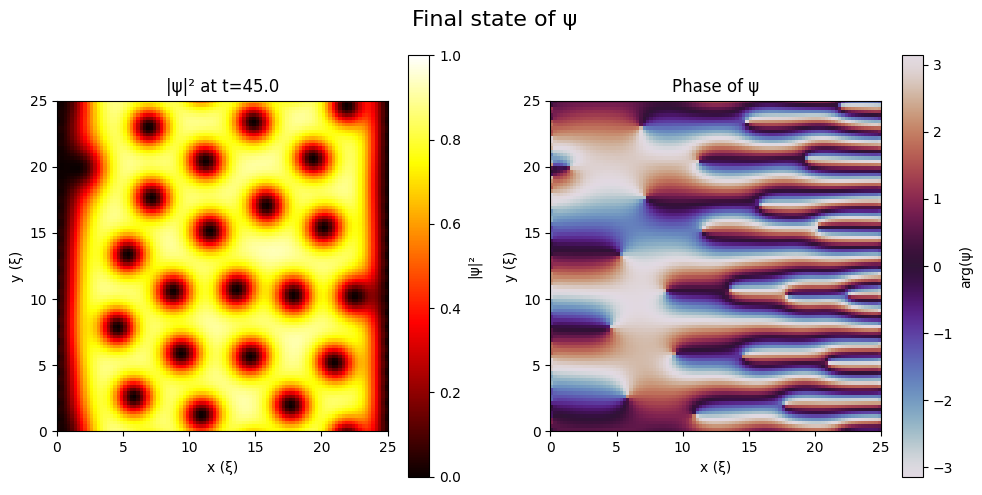

In [24]:

# Visualization
fig1, axes = plt.subplots(2, 5, figsize=(24, 8))
fig1.suptitle('Time Evolution of |ψ|²', fontsize=16)

for idx in range(min(10, len(psi_history))):
    ax = axes.flat[idx]
    psi_snap = psi_history[idx]
    
    im = ax.imshow(np.abs(psi_snap)**2, extent=[0, Lx, 0, Ly], 
                   cmap="viridis", vmin=0, vmax=1, origin='lower')
    ax.set_title(f"t = {time_points[idx]:.1f}")
    ax.set_xlabel("x (ξ)")
    ax.set_ylabel("y (ξ)")
    plt.colorbar(im, ax=ax, label='|ψ|²', fraction=0.046)

# Final state analysis
density = np.abs(final_psi)**2
phase = np.angle(final_psi)

fig2, axes2 = plt.subplots(1, 2, figsize=(10, 5))
fig2.suptitle('Final state of ψ', fontsize=16)

# Density
im1 = axes2[0].imshow(density, extent=[0, Lx, 0, Ly], cmap="hot", 
                      vmin=0, vmax=1, origin='lower')
axes2[0].set_title(f"|ψ|² at t={time_points[-1]:.1f}")
axes2[0].set_xlabel("x (ξ)")
axes2[0].set_ylabel("y (ξ)")
plt.colorbar(im1, ax=axes2[0], label="|ψ|²")

# Phase
im2 = axes2[1].imshow(phase, extent=[0, Lx, 0, Ly], cmap="twilight", origin='lower')
axes2[1].set_title("Phase of ψ")
axes2[1].set_xlabel("x (ξ)")
axes2[1].set_ylabel("y (ξ)")
plt.colorbar(im2, ax=axes2[1], label="arg(ψ)")

plt.tight_layout()
plt.show()